# Data
#### In this homework, we will use the Credit Card Data from the book "Econometric Analysis"
#### The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column 'card')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold

In [2]:
df_original = pd.read_csv(r'./AER_credit_card_data.csv')
df_original.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


# Preparation
- #### Create the target variable by mapping yes to 1 and no to 0
- #### Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use 'train-test-split' function for that with random_state=1

In [3]:
# First we will need to see which column has null values.
df_original.isnull().sum()

card           0
reports        0
age            0
income         0
share          0
expenditure    0
owner          0
selfemp        0
dependents     0
months         0
majorcards     0
active         0
dtype: int64

In [4]:
# Since the dataset doesn't have any null values, we'll go straight to converting the card column to 1 and 0, 
# then split it into tran/validation/test.

df_original['card'] = df_original['card'].map(lambda x: int(x == 'yes'))
df_original.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [5]:
df_full_train, df_test = train_test_split(df_original, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

# Question 1
#### ROC AUC could be used to evaluate feature importance of numerical variables. Let's do that. For each numerical variable, use it as score and compute AUC with the 'card' variable. Use the training dataset. 
#### If your AUC < 0.5, invert this variable by making it by putting a '-' in front such as `"-df_train['expenditure']"`. AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negatin this variable.
#### Which numerical variable has the highest AUC?
- #### reports
- #### dependents
- #### active
- #### share

In [6]:
# Check the data type of each column
df_train.dtypes

reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

In [7]:
# Get the numerical columns, which in this case we can use columns that aren't object types.
numerical_columns = list(df_train.dtypes[df_train.dtypes !='object'].index)
numerical_columns

['reports',
 'age',
 'income',
 'share',
 'expenditure',
 'dependents',
 'months',
 'majorcards',
 'active']

In [8]:
def compare_auc(tol, cols):
    auc_dict = {}
    choices = ['reports', 'dependents', 'active', 'share']
    for c in cols:
        auc = roc_auc_score(y_train, df_train[c])
        if auc < tol:
            auc = roc_auc_score(y_train, -df_train[c])
        print(f'The feature {c} yields an AUC of {auc.round(3)}')
        if c in choices:
            auc_dict[c] = auc
        
    max_key = max(auc_dict, key=auc_dict.get)
    max_value = auc_dict[max_key].round(3)
    ans = 'Out of the choices given, {} yields the highest AUC score with {}'.format(max_key, max_value)
    return ans

In [9]:
tolerance = 0.5

compare_auc(tolerance, numerical_columns)

The feature reports yields an AUC of 0.717
The feature age yields an AUC of 0.524
The feature income yields an AUC of 0.591
The feature share yields an AUC of 0.989
The feature expenditure yields an AUC of 0.991
The feature dependents yields an AUC of 0.533
The feature months yields an AUC of 0.529
The feature majorcards yields an AUC of 0.534
The feature active yields an AUC of 0.604


'Out of the choices given, share yields the highest AUC score with 0.989'

# Training the model
#### From now on, use these columns only: `["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]`
#### Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters
`LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`

In [10]:
columns = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

dv = DictVectorizer(sparse=False)

train_dict = df_train[columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

# Question 2
#### What's the AUC of this model on the validation dataset? (round to 3 digits)
- #### 0.615
- #### 0.515
- #### 0.715
- #### 0.995

In [11]:
roc_auc_score(y_val, y_pred).round(3)

0.995

#### Our logistic regression model yields an ROC AUC score of 0.995

# Question 3
#### Now let's compute the precision and recall for our model
- #### Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
- #### For each threshold, compute precision and recall
- #### Plot them
#### At which threshold do precision and recall intersect?
- #### 0.1
- #### 0.3
- #### 0.6
- #### 0.8 

In [12]:
def confusion_matrix(tols):
    scores = []

    for t in tols:
        actual_pos = (y_val == 1)
        actual_neg = (y_val == 0)

        predict_pos = (y_pred >= t)
        predict_neg = (y_pred < t)

        tp = (predict_pos & actual_pos).sum()
        tn = (predict_neg & actual_neg).sum()

        fp = (predict_pos & actual_neg).sum()
        fn = (predict_neg & actual_pos).sum()

        scores.append((t, tp, fp, fn, tn))
    
    cols = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=cols)

    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    
    return df_scores

In [35]:
thresholds = np.linspace(0, 1, 101)

df_scores = confusion_matrix(thresholds)
df_scores[::10]

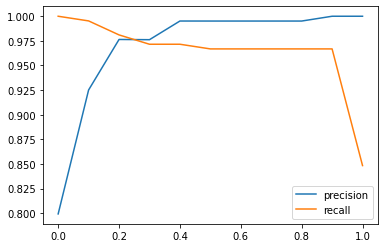

In [14]:
plt.plot(df_scores.threshold, df_scores.precision, label='precision')
plt.plot(df_scores.threshold, df_scores.recall, label='recall')
plt.legend()

#### It looks like the precision and recall scores intersect at a threshold of about 0.3

# Question 4
#### Precision and recall are conflicting - when one increases, the other decreases. That's why they are often combined into the F1 score - a metric that takes into account both. The formula for computing F1 is: F1 = 2(P*R / (P+R))
#### Let's compute F1 for all thresholds in [0, 1] with increment 0.01 using the valiation dataset. At which threshold is F1 maximal?
- #### 0.1
- #### 0.4
- #### 0.6
- #### 0.7

#### To do this we will write a function that takes in a subset of df_scores that has thresholds, precision scores, and recall scores, then calculates the F1 score for each threshold and its respective precision and recall.

In [15]:
def calculate_F1(df):
    F1_scores = {}
    for row in df.itertuples():
        F1 = (2 * row[2] * row[3]) / (row[2] + row[3])
        F1_scores[row[1]] = F1
    max_tol = max(F1_scores, key=F1_scores.get)
    max_F1 = F1_scores[max_tol]
    ans = 'A threshold of {} yields the highest F1 score with {}'.format(max_tol, max_F1)
    plt.plot(F1_scores.keys(), F1_scores.values(), label='F1 scores')
    return ans

'A threshold of 0.35000000000000003 yields the highest F1 score with 0.9832134292565947'

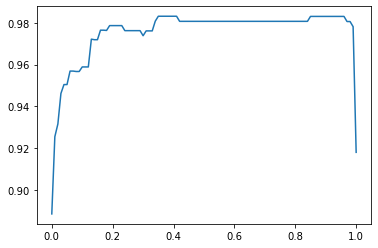

In [16]:
F1_df = df_scores[['threshold', 'precision', 'recall']]
calculate_F1(F1_df)

#### Given the choices in Question 4, we will say a threshold of 0.4 yields the highest F1 score.

# Question 5
#### Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds: `KFold(n_splits=5, shuffle=True, random_state=1)`
- #### Iterate over the different folds of `df_full_train`
- #### Split the data into train and validation
- #### Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
- #### Use AUC to evaluate the model on validation.
#### How large is standard deviation of the AUC scores across different folds?
- #### 0.003
- #### 0.014
- #### 0.09
- #### 0.24

In [17]:
def train(df, y, c):   
    dicts = df[columns].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
    model.fit(X_train, y)
    
    return dv, model

In [18]:
def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [19]:
def analyze_kfold(df, kfold):
    scores = []
    
    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

    df_full_train = df_full_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        y_train = df_train.card.values
        y_val = df_val.card.values
        
        dv, model = train(df_train, y_train, 1.0)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    ans = 'The mean and std of the AUC across different folds are %.3f +- %.3f' % (np.mean(scores), np.std(scores))
    return ans

In [20]:
kfold_split = KFold(n_splits=5, shuffle=True, random_state=1)

In [21]:
analyze_kfold(df_original, kfold_split)

'The mean and std of the AUC across different folds are 0.996 +- 0.003'

# Question 6
#### Now let's use 5-fold cross-validation to find the best parameter C
- #### Iterate over the following values: `[0.01, 0.1, 1, 10]`
- #### Initialize `KFold` with the same paramters as previously
- #### Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
- #### Compute the mean and std (round to 3 decimal digits)

#### Which C leads to the best mean score? If you have ties, select the score with the lowest std and smallest C.

In [22]:
def analyze_kfold_c(c_list):
    for C in c_list:
        kfold = KFold(n_splits=5, shuffle=True, random_state=1)

        scores = []

        for train_idx, val_idx in kfold.split(df_full_train):
            df_train = df_full_train.iloc[train_idx]
            df_val = df_full_train.iloc[val_idx]

            y_train = df_train.card.values
            y_val = df_val.card.values

            dv, model = train(df_train, y_train, C)
            y_pred = predict(df_val, dv, model)

            auc = roc_auc_score(y_val, y_pred)
            scores.append(auc)
            
        print('C=%s gives us a mean and std of %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

In [23]:
analyze_kfold_c([0.01, 0.1, 1, 10])

C=0.01 gives us a mean and std of 0.992 +- 0.006
C=0.1 gives us a mean and std of 0.995 +- 0.004
C=1 gives us a mean and std of 0.996 +- 0.003
C=10 gives us a mean and std of 0.996 +- 0.003


#### We see that both 1 and 10 give the highest mean of 0.996 and both have the same std of 0.003, so we will go with C=1 as our answer.